## Cross species mapping with MapMyCells

In this notebook, we will demonstrate how to map data from one species onto a taxonomy defined in another.

We will take as our data, single nucleus RNA seq data from the rat ventral tegmental area as published in [Phillips et al. 2022](https://www.cell.com/cell-reports/pdf/S2211-1247(22)00364-3.pdf).

First, you must download the data from [this page](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE168156) (see the `http` link for `GSE168156_RAW.tar` at the bottom). Move the resulting `.tar` file into a directory and untar it. Store the directory as `data_dir` below.

In [1]:
import os
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import pathlib
data_dir = pathlib.Path('data/rat')

In [3]:
expected_data_list = [
    pathlib.Path('data/rat/GSE168156_RAW.tar'),
    pathlib.Path('data/rat/GSM5130024_F1_barcodes.tsv.gz'),
    pathlib.Path('data/rat/GSM5130024_F1_features.tsv.gz'),
    pathlib.Path('data/rat/GSM5130024_F1_matrix.mtx.gz'),
    pathlib.Path('data/rat/GSM5130025_F2_barcodes.tsv.gz'),
    pathlib.Path('data/rat/GSM5130025_F2_features.tsv.gz'),
    pathlib.Path('data/rat/GSM5130025_F2_matrix.mtx.gz'),
    pathlib.Path('data/rat/GSM5130026_M1_barcodes.tsv.gz'),
    pathlib.Path('data/rat/GSM5130026_M1_features.tsv.gz'),
    pathlib.Path('data/rat/GSM5130026_M1_matrix.mtx.gz'),
    pathlib.Path('data/rat/GSM5130027_M2_barcodes.tsv.gz'),
    pathlib.Path('data/rat/GSM5130027_M2_features.tsv.gz'),
    pathlib.Path('data/rat/GSM5130027_M2_matrix.mtx.gz')
]
actual_data_list = sorted([n for n in data_dir.iterdir() if n.is_file()])
msg = ""
for pth in expected_data_list:
    if pth not in actual_data_list:
        msg += f"{pth}\n"
if len(msg) > 0:
    raise RuntimeError(
        "You seem not to have downloaded and untarred the data; the following files were missing:\n"
        f"{msg}"
    )

## Create h5ad file for mapping

The data you downloaded exists as a series of tsv and mtx files. We must collect these into a single h5ad file for mapping with MapMyCells.

Each triplet of barcodes.tsv, features.tsv, and matrix.mtx file represents data from a single donor. We will create separate AnnData objects for each of these, concatenate them into a single AnnData object, and write that out into one h5ad file.

In [4]:
working_dir = data_dir / 'working'
if not working_dir.exists():
    working_dir.mkdir(parents=True)

In [5]:
import anndata
import gzip
import numpy as np
import scipy.sparse
import pandas as pd
import re

The barcodes.tsv file is just a list of barcodes. These are the labels of the cells taken from the donor, **which are only unique to this donor**.

The features.tsv file lists the genes. It has three columns: the ENSEMBL ID of the gene, the gene symbol, and an annotation describing the type of gene.

The matrix.mtx file contains the actual gene expression data. It has three columns:
- gene_index
- cell_index (relative to *this*) mtx file
- expression value

In [6]:
def create_anndata_obj(
        obs_prefix,
        barcode_path,
        feature_path,
        matrix_path):
    """
    Create an AnnData object for a single (barcodes, features, matrix) triplet

    Parameters
    ----------
    prefix:
        a str; prefix prepended to cell barcodes to keep them unique
        across the whole dataset
    barcode_path:
        path to the barcode.tsv file
    feature_path:
        path to the features.tsv file
    matrix_path:
        path to the matrix.mtx file

    Returns
    -------
    an anndata.AnnData object
    """
    raw_obs = pd.read_csv(
        barcode_path,
        delimiter='\t',
        names=['barcode']
    )
    obs = pd.DataFrame([{'cell': f'{obs_prefix}_{b}'} for b in raw_obs.barcode.values]).set_index('cell')

    var = pd.read_csv(
        feature_path,
        delimiter='\t',
        names=['ENSEMBL', 'symbol', 'annotation']
    ).set_index('ENSEMBL')

    x_arr = np.zeros((len(obs), len(var)), dtype=np.int32)

    with gzip.open(matrix_path, 'r') as src:
        _ = src.readline()
        _ = src.readline()
        header = src.readline()
    header = header.split()
    n_cells = int(header[1])
    n_genes = int(header[0])
    n_vals = int(header[2])
    assert n_genes == len(var)
    assert n_cells == len(obs)

    data = pd.read_csv(
        matrix_path,
        delimiter=' ',
        names=['gene_idx', 'cell_idx', 'val'],
        dtype={'gene_idx': int, 'cell_idx': int, 'val': np.int32},
        skiprows=3
    )
    assert len(data) == n_vals
    x_arr[data.cell_idx.values-1, data.gene_idx.values-1] = data.val.values
    x_arr = scipy.sparse.csr_matrix(x_arr)
    assert len(x_arr.data) == n_vals

    adata = anndata.AnnData(
        X=x_arr,
        obs=obs,
        var=var
    )
    return adata

In [7]:
barcode_file_list = sorted([n for n in expected_data_list if 'barcodes' in n.name])

In [8]:
adata_list = []
for barcode_path in barcode_file_list:
    print(f'PROCESSING {barcode_path.name}')
    prefix = barcode_path.name.split('_barcode')[0]
    parent = barcode_path.parent
    feature_path = parent / barcode_path.name.replace('barcodes', 'features')
    matrix_path = parent / barcode_path.name.replace('barcodes.tsv.gz', 'matrix.mtx.gz')
    adata_list.append(
        create_anndata_obj(
            obs_prefix=prefix,
            barcode_path=barcode_path,
            feature_path=feature_path,
            matrix_path=matrix_path
        )
    )
    

PROCESSING GSM5130024_F1_barcodes.tsv.gz
PROCESSING GSM5130025_F2_barcodes.tsv.gz
PROCESSING GSM5130026_M1_barcodes.tsv.gz
PROCESSING GSM5130027_M2_barcodes.tsv.gz


Now, combine the AnnData objects we have created into one and write it out to a single file

In [9]:
query_path = working_dir / 'rat_query_data.h5ad'
full_adata = anndata.concat(adata_list)
full_adata.write_h5ad(
    query_path,
    compression='gzip',
    compression_opts=4
)
del full_adata

## Map the data to the Whole Mouse Brain taxonom with MapMyCells

In order to run MapMyCells on the h5ad file we just created we are going to need some supporting files, namely
- The files that define the taxonomy itself
- A database file that will handle the mapping between the rat genes in our query data and the mouse genes in the taxonomy

The python API provided by `abc_atlas_access` will allow us to download those files.

In [10]:
import cell_type_mapper.test_utils.cache_wrapper as cache_module
abc_cache_dir = pathlib.Path('data/abc_cache')
abc_cache = cache_module.AbcCacheWrapper.from_cache_dir(abc_cache_dir)

Download the `precomputed_stats` and query marker lookup files defining the Whole Mouse Brain taxonomy.

In [11]:
wmb_precomputed_stats_path = abc_cache.get_data_path(
    directory='WMB-taxonomy',
    file_name='precomputed_stats_ABC_revision_230821'
)

wmb_query_marker_path = abc_cache.get_data_path(
    directory='WMB-taxonomy',
    file_name='mouse_markers_230821'
)

Download the database file that will handle the cross-species gene mapping.

In [12]:
gene_mapper_db_path = abc_cache.get_data_path(
    directory='mmc-gene-mapper',
    file_name='mmc_gene_mapper.2025-08-04'
)

In [13]:
from cell_type_mapper.cli.from_specified_markers import FromSpecifiedMarkersRunner

In [14]:
mapping_path = working_dir / 'rat_mapped_to_wmb.json'

config = {
    "precomputed_stats": {
        "path": str(wmb_precomputed_stats_path)
    },
    "query_markers": {
        "serialized_lookup": str(wmb_query_marker_path)
    },
    "drop_level": "CCN20230722_SUPT",
    "query_path": str(query_path),
    "extended_result_path": str(mapping_path),
    "type_assignment": {
        "n_processors": 4,
        "normalization": "raw"
    },
    "verbose_stdout": True,
    "gene_mapping": {
        "db_path": str(gene_mapper_db_path)
    }
}

In [15]:
%%time
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()

=== Running Hierarchical Mapping 1.6.0 with config ===
{
  "type_assignment": {
    "bootstrap_factor": 0.5,
    "rng_seed": 11235813,
    "normalization": "raw",
    "log_level": "ERROR",
    "bootstrap_factor_lookup": null,
    "chunk_size": 10000,
    "n_runners_up": 5,
    "min_markers": 10,
    "n_processors": 4,
    "bootstrap_iteration": 100
  },
  "query_gene_id_col": null,
  "precomputed_stats": {
    "log_level": "ERROR",
    "path": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/WMB-taxonomy/20240831/precomputed_stats_ABC_revision_230821.h5"
  },
  "extended_result_path": "data/rat/working/rat_mapped_to_wmb.json",
  "tmp_dir": null,
  "flatten": false,
  "summary_metadata_path": null,
  "csv_result_path": null,
  "query_markers": {
    "log_level": "ERROR",
    "serialized_lookup": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/WMB-taxonomy/20240831/mouse_markers_230821.json",
    "

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/cli/cli_log.py:73: UserWarning: numpy's internal parallelization is enabled. This could cause independent worker processes to compete for resources, degrading performance. We recommend setting the following environment variables to '1' to improve performance
{
  "NUMEXPR_NUM_THREADS": "",
  "MKL_NUM_THREADS": "",
  "OMP_NUM_THREADS": ""
}
  warnings.warn(msg)
/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


***Checking to see if we need to map query genes onto reference dataset
====Based on 32285 genes, your input data is from species 'Balb/c mouse:10090'
Reference data belongs to species Balb/c mouse:10090
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Balb/c mouse:10090 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 20203 genes, your input data is from species 'brown rat:10116'
Input genes are from species 'brown rat:10116'
Mapping 12680 input genes from 'symbols' to 'NCBI' (e.g. ['ENSRNOG00000046319' 'ENSRNOG00000047964' 'ENSRNOG00000050370'
 'ENSRNOG00000032365' 'ENSRNOG00000058808'])
Mapping input genes from 'ENSEMBL' to 'NCBI'
Mapping genes from species 'brown rat:10116' to 'Balb/c mouse:10090'
Mapping input genes from 'NCBI' to 'ENSEMBL'
***Mapping of query genes to reference dataset comple

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/cli/cli_log.py:73: UserWarning: 1369 marker genes were not present in the query dataset. They have been ignored
  warnings.warn(msg)


BENCHMARK: spent 3.6256e-01 seconds creating query marker cache
Scanning unlabeled data to check that it is >= 0
Verified that unlabeled data is >= 0
Running CPU implementation of type assignment.


/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/diff_exp/score_utils.py:303: UserWarning: precomputed stats file does not have 'ge1' data
  warnings.warn("precomputed stats file does not have 'ge1' data")


BENCHMARK: spent 5.2576e+01 seconds assigning cell types
Writing marker genes to output file
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP
CPU times: user 33.4 s, sys: 31.3 s, total: 1min 4s
Wall time: 1min 10s


In [16]:
import json
with open(mapping_path, 'rb') as src:
    mapping = json.load(src)

In [17]:
import cell_type_mapper.taxonomy.taxonomy_tree as tree_module
taxonomy_tree = tree_module.TaxonomyTree(data=mapping['taxonomy_tree'])

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


In [18]:
level = 'CCN20230722_CLAS'
mouse_assignments = [
    taxonomy_tree.label_to_name(
        level=level,
        label=cell[level]['assignment']
    )
    for cell in mapping['results']
]

In [19]:
print(len(set(mouse_assignments)))

29


In [20]:
import matplotlib.pyplot as plt

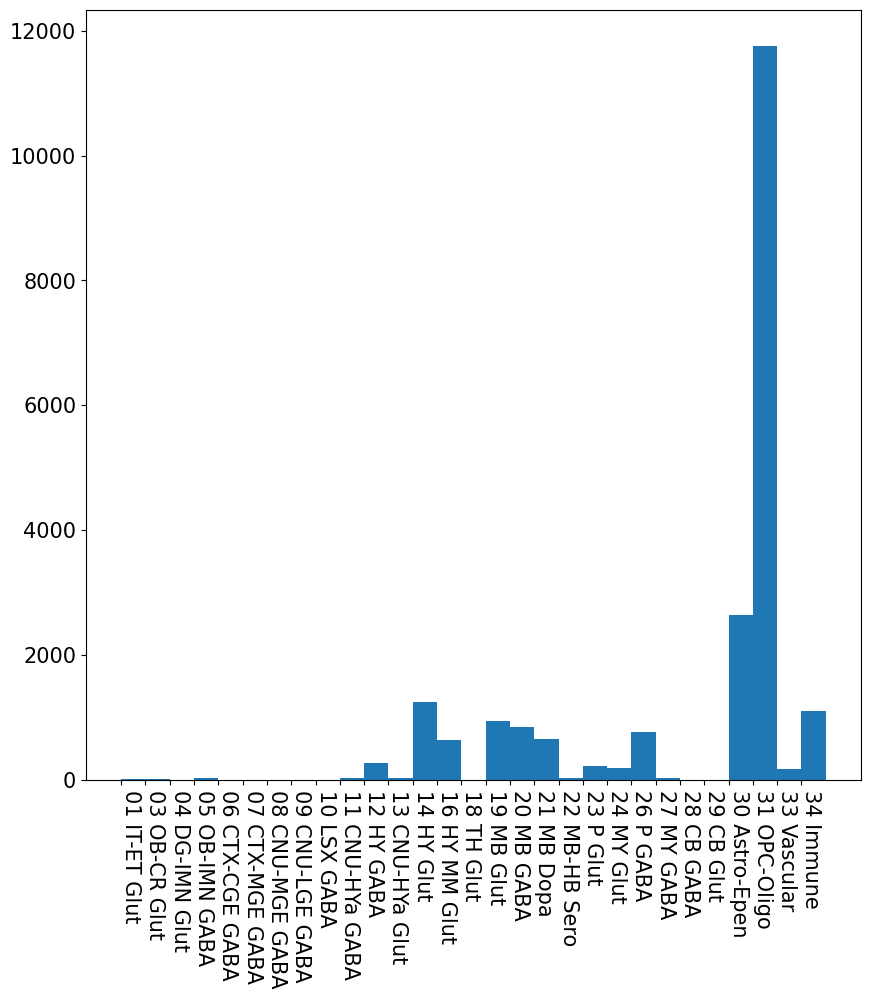

In [21]:
fontsize = 15
assignment_val = sorted(set(mouse_assignments))
assignment_to_idx = {a: ii for ii, a in enumerate(assignment_val)}
assn_idx = [assignment_to_idx[a] for a in mouse_assignments]
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1,1,1)
_ = axis.hist(assn_idx, np.arange(len(assignment_val)+1))
ticks = [ii for ii in range(len(assignment_val))]
axis.set_xticks(ticks, assignment_val, va='top', ha='left')
axis.tick_params(
    which='both',
    axis='both',
    labelsize=fontsize
)
axis.tick_params(
    axis='x',
    labelrotation=-90.0
)

## Visualize in UMAP

In [22]:
import sklearn
import umap

In [23]:
cluster_annotation_term_df = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_annotation_term'
)

In [24]:
color_lookup = dict()
for node, level, color in zip(cluster_annotation_term_df.label.values,
                              cluster_annotation_term_df.cluster_annotation_term_set_label.values,
                              cluster_annotation_term_df.color_hex_triplet.values):
    if level not in color_lookup:
        color_lookup[level] = dict()
    name = taxonomy_tree.label_to_name(
        level=level,
        label=node
    )
    color_lookup[level][name] = color

In [48]:
def create_embedding(data, n_pca=0, umap_metric='cosine'):
    if n_pca > 0:
        pca = sklearn.decomposition.PCA(n_components=n_pca)
        xx = pca.fit_transform(data)
    else:
        xx = data
    umapper = umap.UMAP(random_state=781321, metric=umap_metric, n_epochs=1000)
    umap_xx = umapper.fit_transform(xx)
    return umap_xx

In [49]:
from matplotlib.patches import Rectangle

def plot_embedding(
        cell_assignments,
        embedding_coords,
        color_lookup,
        legend=True):
    rng = np.random.default_rng(22131)
    idx = np.arange(len(cell_assignments))
    rng.shuffle(idx)
    cell_assignments = np.array(cell_assignments)[idx]
    embedding_coords = embedding_coords[idx, :]
    fig = plt.figure(figsize=(10,10))
    axis = fig.add_subplot(1, 1, 1)
    color_arr = [
        color_lookup[a] for a in cell_assignments
    ]
    axis.scatter(
        embedding_coords[:, 0],
        embedding_coords[:, 1],
        c=color_arr,
        s=2
    )
    min_x = embedding_coords[:, 0].min()
    max_x = embedding_coords[:, 0].max()
    dx = max_x-min_x
    axis.set_xlim((min_x-dx/2, max_x+dx/10))
    if legend:
        color_blocks = []
        label_values = np.unique(cell_assignments)
        for val in label_values:
            color_blocks.append(Rectangle((0, 0), 1, 1, fc=color_lookup[val]))
        _ = axis.legend(color_blocks, label_values, loc=0)

In [50]:
src = anndata.read_h5ad(query_path)
cell_by_gene = src.X.toarray()

In [51]:
%%time
embedding = create_embedding(cell_by_gene, n_pca=30, umap_metric='correlation')

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: user 46.8 s, sys: 1.95 s, total: 48.7 s
Wall time: 45.4 s


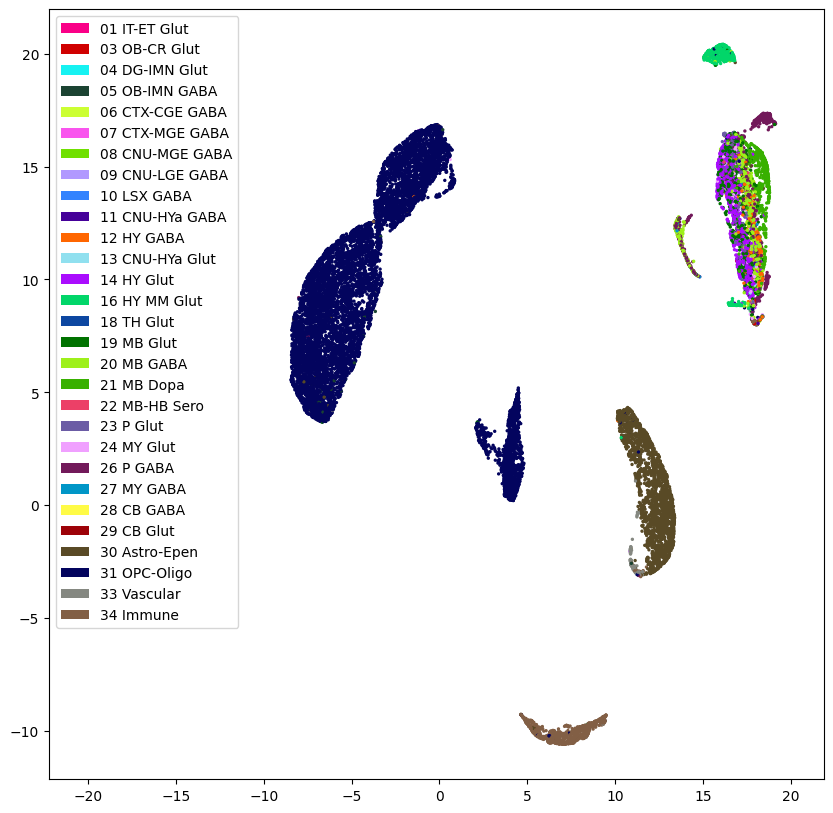

In [52]:
plot_embedding(
    cell_assignments=mouse_assignments,
    embedding_coords=embedding,
    color_lookup=color_lookup['CCN20230722_CLAS'],
    legend=True)

/Users/scott.daniel/miniconda3/envs/rat_notebook/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


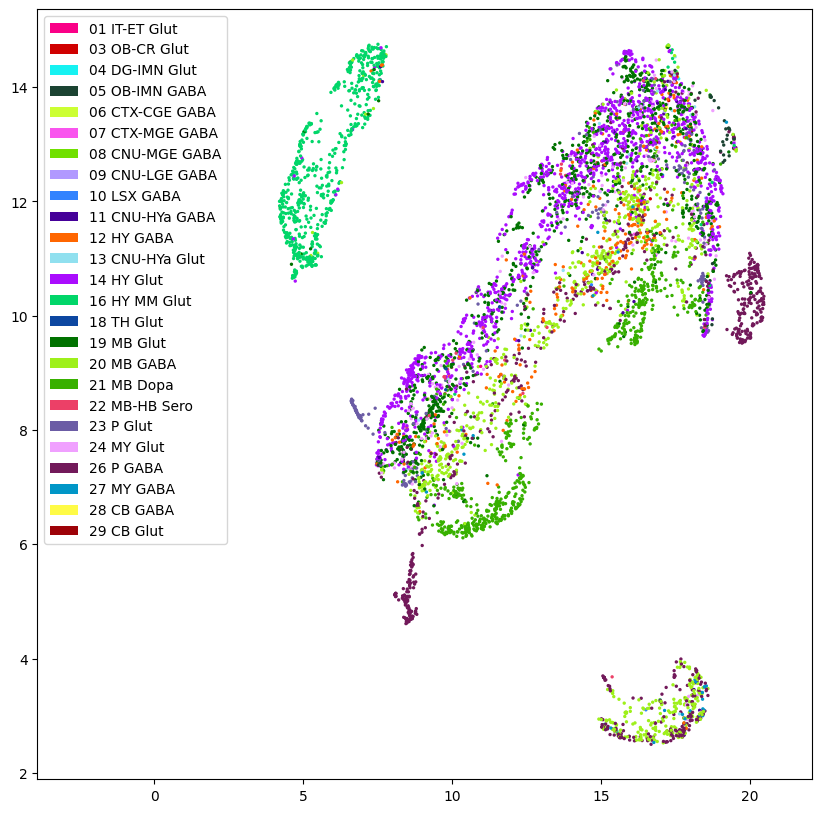

In [53]:
neuron_idx = np.array([
    ii for ii in range(len(mouse_assignments))
    if 'Vascular' not in mouse_assignments[ii]
    and 'Astro-Epen' not in mouse_assignments[ii]
    and 'OPC-Oligo' not in mouse_assignments[ii]
    and 'Immune' not in mouse_assignments[ii]
])
mouse_neurons = np.array(mouse_assignments)[neuron_idx]
neuron_x = cell_by_gene[neuron_idx, :]

neuron_embedding = create_embedding(neuron_x, n_pca=30, umap_metric='correlation')
plot_embedding(
    cell_assignments=mouse_neurons,
    embedding_coords=neuron_embedding,
    color_lookup=color_lookup['CCN20230722_CLAS'],
    legend=True)

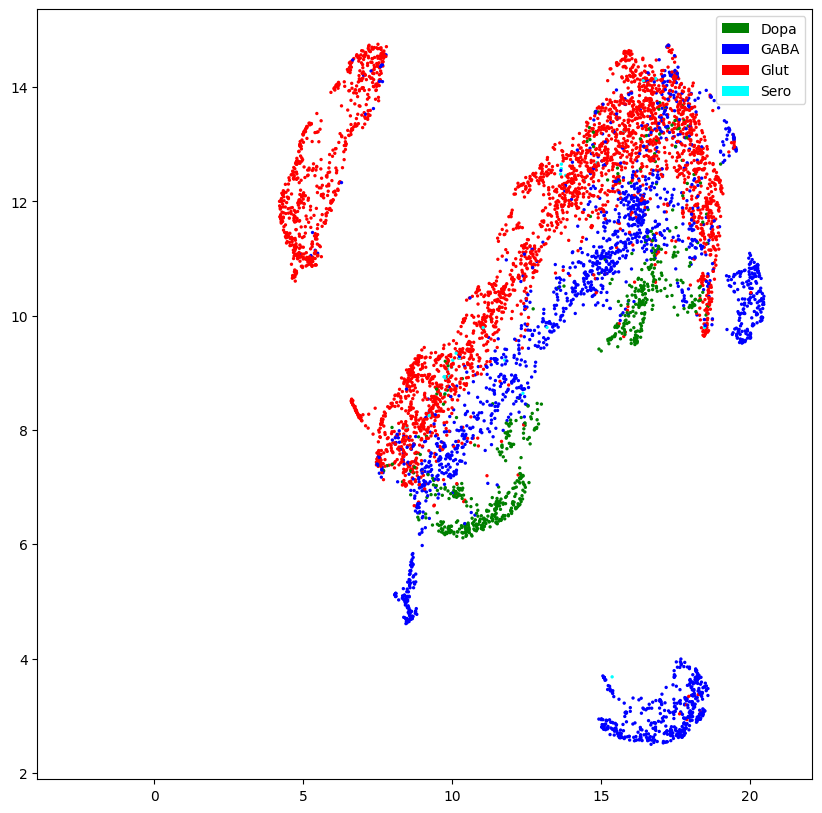

In [54]:
brute_nt = []
for cell in mouse_neurons:
    nt = None
    for tag in ('GABA', 'Glut', 'Dopa', 'Sero'):
        if tag in cell:
            nt = tag
            break
    assert nt is not None
    brute_nt.append(nt)

nt_color_map = {
    'GABA': 'blue',
    'Glut': 'red',
    'Dopa': 'green',
    'Sero': 'cyan'
}
plot_embedding(
    cell_assignments=brute_nt,
    embedding_coords=neuron_embedding,
    color_lookup=nt_color_map,
    legend=True
)